# MSDS 7331 - Project 1 - Visualization
## Team: Dineen Parker, Dale Legband, Ryan Shuhart

In [1]:
### Modules Used ###

# Pandas Module for data manipulation
import pandas as pd

# pandas_profiling is a handy tool for inspecting data
# https://github.com/JosPolfliet/pandas-profiling
# pip install pandas-profiling
import pandas_profiling

# seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Page settings - might not need...
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

# Prevents scientific notation formatting issues. Limits floats to one decimal place.
pd.set_option('display.float_format', lambda x: '%.1f' % x) 

# Business Understanding (10 points total).
* Describe the purpose of the data set you selected (i.e., why was this data collected in
the first place?). 
* Describe how you would define and measure the outcomes from the
dataset. That is, why is this data important and how do you know if you have mined
useful knowledge from the dataset? 
* How would you measure the effectiveness of a
good prediction algorithm? Be specific.

From CRISP-DM article (https://mineracaodedados.files.wordpress.com/2012/04/the-crisp-dm-model-the-new-blueprint-for-data-mining-shearer-colin.pdf):
* What are the measures of success?
* Are there any assumptions?
* Create a glossary, if needed

# Data Understanding (80 points total)

* [15 points] Verify data quality: Explain any missing values, duplicate data, and outliers.
Are those mistakes? How do you deal with these problems? Give justifications for your
methods.

* [10 points] Visualize appropriate statistics (e.g., range, mode, mean, median, variance,
counts) for a subset of attributes. Describe anything meaningful you found from this or if
you found something potentially interesting. Note: You can also use data from other
sources for comparison. Explain why the statistics run are meaningful.

* [15 points] Visualize the most interesting attributes (at least 5 attributes, your opinion
on what is interesting). Important: Interpret the implications for each
visualization. Explain for each attribute why the chosen visualization is appropriate.

* [15 points] Visualize relationships between attributes: Look at the attributes via scatter
plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain
any interesting relationships.

* [10 points] Identify and explain interesting relationships between features and the class
you are trying to predict (i.e., relationships with variables and the target classification).

* [5 points] Are there other features that could be added to the data or created from
existing features? Which ones?

### Collect Initial Data
Data comes from the UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The given description: <br>
"This research aimed at the case of customer default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default."



### Description of the Data per Offical Documentation
    
**LIMIT_BAL** (Ratio): Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
**SEX** (Nominal): Gender (1 = male; 2 = female)<br>
**EDUCATION** (Nominal): Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)<br>
**MARRIAGE** (Nominal): Marital status (1 = married; 2 = single; 3 = others)<BR>
**AGE** (Interval): Age (year)<BR>
**PAY_0_Sept - PAY_6_April** (Ordinal): History of past payment. The past monthly payment records (from April to September, 
2005). The measurement scale for the repayment status is: <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-1 = pay duly<BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - 8 = payment delay for one to eight months <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9 = payment delay for nine months and above<BR>
**BILL_AMT1_Sept - BILL_AMT6_April** (Ratio): Amount of bill statement (NT dollar) <BR>
**PAY_AMT1_Sept - PAY_AMT6_April** (Ratio): Amount of previous payment (NT dollar) <BR>
**default payment next month** (Nominal): default payment (Yes = 1, No = 0)

In [23]:
# First row are for reference with header starting on line 2.
# ID field is use as the index field in the data frame
# Month specific columns renamed with month for readability
cc_data = (pd.read_excel("./cc_data/default of credit card clients.xls", skiprows=1, index_col='ID')
             .rename(columns={'PAY_0':'PAY_0_Sept', #No Pay_1
                              'PAY_2':'PAY_2_Aug', 
                              'PAY_3':'PAY_3_July', 
                              'PAY_4':'PAY_4_June',
                              'PAY_5':'PAY_5_May',
                              'PAY_6':'PAY_6_April',
                              'BILL_AMT1':'BILL_AMT1_Sept', 
                              'BILL_AMT2':'BILL_AMT2_Aug', 
                              'BILL_AMT3':'BILL_AMT3_July', 
                              'BILL_AMT4':'BILL_AMT4_June', 
                              'BILL_AMT5':'BILL_AMT5_May',
                              'BILL_AMT6':'BILL_AMT6_April', 
                              'PAY_AMT1':'PAY_AMT1_Sept', 
                              'PAY_AMT2':'PAY_AMT2_Aug', 
                              'PAY_AMT3':'PAY_AMT3_July', 
                              'PAY_AMT4':'PAY_AMT4_June', 
                              'PAY_AMT5':'PAY_AMT5_May',
                              'PAY_AMT6':'PAY_AMT6_April'
                             })
             # Due to the many age values, creating age brackets
             .assign(age_range = lambda x: pd.cut(x['AGE'],[20,30,40,50,60,70,120], 6, 
                                                 labels=['21-30','31-40','41-50','51-60','61-70','71-80+']))
             # this creates a new variable for LIMIT_BAL_brackets
             .assign(LIMIT_BAL_range = lambda x: pd.cut(x['LIMIT_BAL'],[0,250000,500000,750000,1e7], 4, 
                                                 labels=['0-250k','>250k-500k','>500k-750k','>750k']))
           )

# Convert numerical representations to category names
cc_data.loc[(cc_data['SEX']==1), 'SEX'] = 'Male'
cc_data.loc[(cc_data['SEX']==2), 'SEX'] = 'Female'

cc_data.loc[(cc_data['EDUCATION']==1), 'EDUCATION'] = 'Graduate School'
cc_data.loc[(cc_data['EDUCATION']==2), 'EDUCATION'] = 'University'
cc_data.loc[(cc_data['EDUCATION']==3), 'EDUCATION'] = 'High School'
cc_data.loc[(cc_data['EDUCATION']==4), 'EDUCATION'] = 'Others'

cc_data.loc[(cc_data['MARRIAGE']==1), 'MARRIAGE'] = 'Married'
cc_data.loc[(cc_data['MARRIAGE']==2), 'MARRIAGE'] = 'Single'
cc_data.loc[(cc_data['MARRIAGE']==3), 'MARRIAGE'] = 'Others'

In [17]:
# For reference and copy/pasting column names
cc_data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0_Sept',
       'PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April',
       'BILL_AMT1_Sept', 'BILL_AMT2_Aug', 'BILL_AMT3_July', 'BILL_AMT4_June',
       'BILL_AMT5_May', 'BILL_AMT6_April', 'PAY_AMT1_Sept', 'PAY_AMT2_Aug',
       'PAY_AMT3_July', 'PAY_AMT4_June', 'PAY_AMT5_May', 'PAY_AMT6_April',
       'default payment next month', 'age_range', 'LIMIT_BAL_range'],
      dtype='object')

### Verify the data quality

In [27]:
# Function to show counts and proportion of a given field
def category_proportion(df, series_name):
    df_counts = pd.DataFrame({series_name + '_Count' : df.groupby(series_name)[series_name].size(), 
                  series_name+'_Prop' : df.groupby(series_name)[series_name].size().apply(
                                        lambda x: float(x) / df.groupby(series_name).size().sum()*100)}).reset_index()
    df_tots = pd.DataFrame({series_name:['_Total'],
              series_name+'_Count':df_counts[series_name + '_Count'].sum(),
              series_name+'_Prop':df_counts[series_name+'_Prop'].sum()})
    return pd.concat([df_counts,df_tots])

# look through categorical variables that have values not defined
cat_vars = ['SEX','EDUCATION','MARRIAGE','default payment next month', 'PAY_0_Sept',
            'PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April', 'age_range', 'LIMIT_BAL_range']

con_vars = ['LIMIT_BAL', 'AGE', 'BILL_AMT1_Sept', 'BILL_AMT2_Aug', 'BILL_AMT3_July', 
            'BILL_AMT4_June','BILL_AMT5_May', 'BILL_AMT6_April', 'PAY_AMT1_Sept', 
            'PAY_AMT2_Aug', 'PAY_AMT3_July', 'PAY_AMT4_June', 'PAY_AMT5_May', 
            'PAY_AMT6_April']

for i in range(len(cat_vars)):
    print(category_proportion(cc_data, cat_vars[i]))
    print()

      SEX  SEX_Count  SEX_Prop
0  Female      18112      60.4
1    Male      11888      39.6
0  _Total      30000     100.0

         EDUCATION  EDUCATION_Count  EDUCATION_Prop
0                0               14             0.0
1                5              280             0.9
2                6               51             0.2
3  Graduate School            10585            35.3
4      High School             4917            16.4
5           Others              123             0.4
6       University            14030            46.8
0           _Total            30000           100.0

  MARRIAGE  MARRIAGE_Count  MARRIAGE_Prop
0        0              54            0.2
1  Married           13659           45.5
2   Others             323            1.1
3   Single           15964           53.2
0   _Total           30000          100.0

  default payment next month  default payment next month_Count  \
0                          0                             23364   
1                    

It appears EDUCATION, MARRIAGE, and PAY_0_Sept-PAY_6_April (history of past payment) have values not defined by the documentation. EDUCATION should only have values 1-4 representing graduate school(1), university(2), high school(3), and others(4), however, has 0, 5, and 6. The undefinded values make up only about 1% of the observations will be imputed to the 'others' category, 4. MARRIAGE documentation states 3 categories, married(1), single(2), and others(3), yet .2% of values are defined as 0. The value 0 for MARRIAGE will be imputed to the 'others' catgory of 3. According to the documentation, PAY_0_Sept-PAY_6_April, should have values -1 or 1-9, however, the data is different and the values range from -2 to 9. Following the logic, -2 must be two months early, -1 one month early, 0 on time, 1 one month late, and so on up to 9 where 9 represents 9 months late or more. Further investigation shows not much difference in default between -2 to 0. 

In [ ]:
# Impute undefined values
cc_data.loc[(~cc_data['EDUCATION'].isin(['Graduate School','University','High School','Others'])), 'EDUCATION'] = 'Others'
cc_data.loc[(cc_data['MARRIAGE']==0), 'MARRIAGE'] = 'Others' 

# recheck
for i in range(len(cat_vars)):
    print(category_proportion(cc_data, cat_vars[i]))
    print()

Categorical data appears to be in better order now.

**Artifacts**:<br>
1 month delays seems to be far more absent in months PAY_2_Aug to PAY_6_April, with PAY_5_May, PAY_6_April not having any at all. This seems rather odd. Only PAY_0_Sept of 1 seems to fit.

Why BILL_AMT1 Minimum-165580<br>

* [10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file.

#### Summary Statistics
- Distribution of Defaults (facet plot)
 - by age
 - by sex
 - by education
 - by marriage
- Distribution of age
- Distribution of sex
- Distribution of education<br><br>
- CC History frequency tables
 - by age
 - by sex
 - by education
 - by marriage

In [ ]:
# cc_data_grouped = cc_data.groupby('MARRIAGE')
# pd.DataFrame({'default payment next month': cc_data_grouped['default payment next month'].sum()
#               /cc_data_grouped['default payment next month'].count()})

cc_data_grouped = cc_data.groupby([cat_vars[4],'default payment next month'])
#print(cc_data_grouped['default payment next month'].sum().unstack())
df1 = cc_data_grouped['default payment next month'].count().unstack().reset_index()
df1['Default Odds'] = (df1[1]/(df1[0]+df1[1]))/(df1[0]/(df1[0]+df1[1]))
df1
#print(cc_data_grouped['default payment next month'].sum().unstack()/cc_data_grouped['default payment next month'].count().unstack())

In [ ]:
sns.lmplot(data=df1, x='PAY_0_Sept', y='Default Odds')

In [ ]:
#Logistic line for 
sns.lmplot(data=cc_data, x='PAY_0_Sept', y='default payment next month', x_jitter=.1, y_jitter=.02, col='SEX', logistic=True)
sns.lmplot(data=cc_data, x='PAY_0_Sept', y='default payment next month', x_jitter=.1, y_jitter=.02, col='EDUCATION', logistic=True)


### Explore the data

In [ ]:
profile = pandas_profiling.ProfileReport(cc_data)
profile.to_file(outputfile="./myoutputfile.html")

In [ ]:
sns.violinplot(data=cc_data, x='default payment next month',y='LIMIT_BAL', hue='SEX', split=True, inner="quart")

# Exceptional Work (10 points total)
* You have free reign to provide additional analyses.
*One idea: implement dimensionality reduction, then visualize and interpret the results.

feature creation ideas:
* Age brackets
* Ratio of Pay Amount to Bill Amount
* Ratio of Bill Amount to LIMIT_BAL
* Transformation of data - scaling

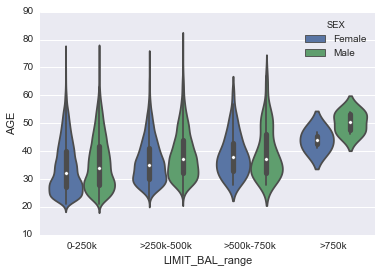

In [25]:
#sns.distplot(cc_data['LIMIT_BAL_range'])
sns.violinplot(data=cc_data, x='LIMIT_BAL_range', y="AGE", hue='SEX')

Sources:
https://www.wakari.io/sharing/bundle/ijstokes/pyvis-1h?has_login=False